# Eventgraphs Tutorial
<a name="top"></a>

This tutorial is structured as follows:
* [Installation](#Installation)
* [Class Structure and IO](#Class-Structure-and-IO)
* [Motif and Inter-event Time Distributions](#Motif-and-Inter-event-Time-Distributions)
* [Component Analysis](#Component-Analysis)
* [Plotting](#Plotting)
* [Feature Analysis and Clustering](#Feature-Analysis-and-Clustering)
* [Centrality](#Centrality)

## Installation

Eventgraphs can be installed using pip, either directly from the Github repostitory, or from PyPI.
To ensure that the software is up to date it is recommended to use the latest version from Github where possible.

#### Install from Github (Latest version, recommended) 

```bash
pip install git+https://github.com/empiricalstateofmind/eventgraphs
```

#### Install from PyPI

```bash
pip install eventgraphs
```

## Class Structure and IO

The main object of eventgraphs is the *EventGraph*.

We use the EventGraph to capture and sanctify incoming data, calculate inter-event times and temporal motifs, and perform a temporal decomposition.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import json

from eventgraphs import EventGraph

### Data Structure

The EventGraph can be constructed using two types of data structure for the set of events.

* `EventGraph.from_pandas_eventlist(data, graph_rules)`: *data* should be in the form of a Pandas DataFrame with minimal columns [source, target, time]. Additional columns can be added including [duration, type]. Any other columns will be included but ignored.
* `EventGraph.from_dict_eventlist(data, graph_rules)`: *data* should be in the form of a dictionary of records of the form {index: {source:, target:, time:}}. Additional entries can be added including [duration, type]. Any other entries will be included but ignored.

*graph_rules* can be one of 'teg', 'pfg', or 'eg' depending on the type of EventGraph required (see more below).

In [6]:
# ~ 2.5 MB download
FILEPATH = 'https://raw.githubusercontent.com/empiricalstateofmind/eventgraphs/master/examples/collective_behaviour_paper/data/twitter_24h.csv'
data = pd.read_csv(FILEPATH)

data.head()

,source,target,time,type
0,75793,69955,4,m
1,69667,79761,6,r
2,17533,65736,7,r
3,84824,74793,9,r
4,111054,81510,9,r


### Building the EventGraph

In [3]:
EG = EventGraph.from_pandas_eventlist(data, graph_rules='teg')

# Alternatively, we can use the dictionary constructor if our data was a dictionary.
# EG = EventGraph.from_dict_eventlist(data, graph_rules='teg')

EG

<EventGraph with 52286 nodes, 143050 events, and 0 edges (status: unbuilt)>

The *event_graph_rules* are a dictionary which prescribe the settings used to build the EventGraph.
These are:
* **delta_cutoff:** How close in temporal proximity two events can be for them to be considered for joining.
* **event_processor:** A function of the two events, returning True if they should be connected. Default behaviour assesses whether the two events are adjacent.
* **subsequential:** A boolean to decide whether we consider only the first subsequent event for joining, or all future events.
* **join_on_object:** Currently not implemented.
* **event_object_processor:** Currently not implemented.

In [4]:
EG.event_graph_rules

{'delta_cutoff': 1000000000.0,
 'event_object_processor': None,
 'event_processor': <function eventgraphs.prebuilt.basic_event_processor>,
 'join_on_object': False,
 'subsequential': True}

In [5]:
EG.event_graph_rules['delta_cutoff'] = 180

In [6]:
EG.build(verbose=True)

The event graph edges can be found as the *EventGraph.eg_edges* table of the EventGraph.

Source and target indices are connected to the *EventGraph.events* table of the EventGraph.

The inter-event time is already calculated for each edge of the EventGraph (here called *delta*)

In [49]:
EG.eg_edges.head()

,delta,motif,source,target
3,64,"●|+ (rt,rt)",2948,3026
11,5,"+|○ (rt,rt)",0,5
12,6,"+|○ (rt,rt)",5,13
13,19,"+|○ (rt,rt)",13,40
14,134,"+|○ (rt,rt)",40,166


Motifs are calculated using the *EventGraph.calculate_edge_motifs* function.

This has control over whether coloured edges are used, or condensed motifs are used (for higher-order events).

Calculated motifs are automatically added to the *EventGraph.eg_edges* table.

In [8]:
EG.calculate_edge_motifs(edge_type='type', condensed=False)

In [50]:
EG.eg_edges.head()

,delta,motif,source,target
3,64,"●|+ (rt,rt)",2948,3026
11,5,"+|○ (rt,rt)",0,5
12,6,"+|○ (rt,rt)",5,13
13,19,"+|○ (rt,rt)",13,40
14,134,"+|○ (rt,rt)",40,166


### EventGraph Operations

There are a number of operations that we can carry out on the EventGraph to change its structure.

These are:
* *EventGraph.filter_edges*: Remove edges based on edge weights (upper or lower bound), or specify edges that belong to a particular motif.
* *EventGraph.filter_events*: Remove events from the EventGraph (and connected edges)


In [10]:
filtered = EG.filter_edges(delta_ub=90)
filtered

<EventGraph with 52286 nodes, 143050 events, and 94660 edges (status: built)>

In [11]:
filtered = EG.filter_edges(motif_types=['●|○ (rt,rt)'])
filtered

<EventGraph with 52286 nodes, 143050 events, and 22886 edges (status: built)>

In [12]:
filtered = EG.filter_events(event_indices=range(100))
filtered

<EventGraph with 91 nodes, 100 events, and 64 edges (status: built)>

### Saving and Loading

For ease of use, there is basic saving/loading functionality as json files.

In [13]:
EG.save('eventgraph.json')

In [14]:
EG = EventGraph.from_file('eventgraph.json')

[[Back to top](#top)]

## Analysis

The tools to analyse EventGraphs are contained in *eventgraphs.analysis*.
Most of the functions in this subpackage take the EventGraph object as the primary argument.

### Motif Distributions

Motif distributions can be calculated from *EventGraph.eg_edges*, or using the helper function from analysis.

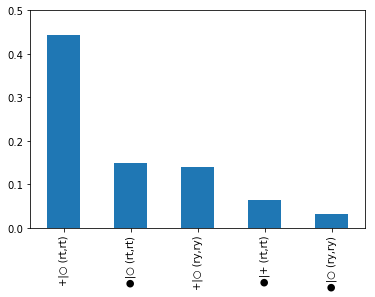

In [51]:
from eventgraphs.analysis import calculate_motif_distribution

motif_distribution = calculate_motif_distribution(EG)

motif_distribution.nlargest().plot(kind='bar', ylim=(0,0.5));

### Inter-event Time Distributions

Similarly, inter-event times distributions have a helper function, with various options.

One of these options is to condition the inter-event times by the type of motif that is formed between the two events.

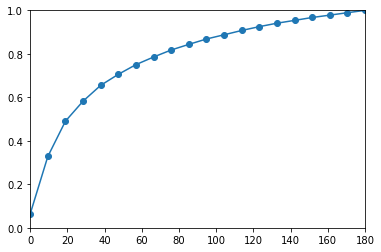

In [52]:
from eventgraphs.analysis import calculate_iet_distribution

iets = calculate_iet_distribution(EG, 
                                  normalize=True, 
                                  cumulative=True, 
                                  bins=np.linspace(0,180,20))

iets.plot(marker='o', xlim=(0,180), ylim=(0,1));

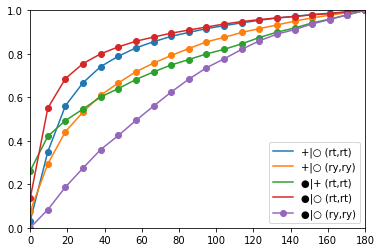

In [53]:
motif_iets = calculate_iet_distribution(EG, 
                                        by_motif=True, 
                                        normalize=True, 
                                        cumulative=True,
                                        bins=np.linspace(0,180,20))

for motif, times in motif_iets.items():
    if motif in motif_distribution.nlargest():
        times.plot(xlim=(0,180), 
                   ylim=(0,1), 
                   label=motif, 
                   logx=False, 
                   legend=True,
                   marker='o')

[[Back to top](#top)]

## Component Analysis

There are also helper functions to analyse the component size distributions, and how they vary with the parameter $\Delta t$.

Note that $\Delta t$ must be less than the $\Delta t$ chosen on initial graph construction.

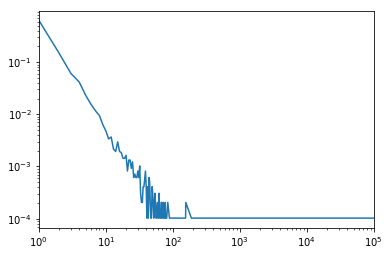

In [54]:
from eventgraphs.analysis import calculate_component_distribution

component_distribution = calculate_component_distribution(EG)

component_distribution.plot(logx=True, 
                            logy=True);

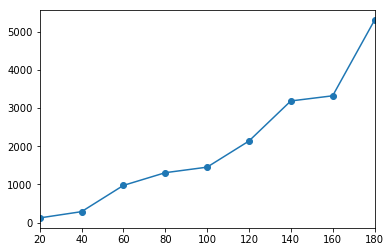

In [55]:
from eventgraphs.analysis import calculate_component_distribution_over_delta

component_distributions, component_max = calculate_component_distribution_over_delta(EG, 
                                                                                np.linspace(20,180,9))

component_max.plot(marker='o');

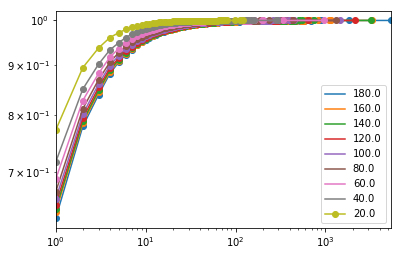

In [56]:
for dt, dist in component_distributions.items():
    dist.cumsum().plot(label=dt, 
                       legend=True,
                       logx=True,
                       logy=True,
                       marker='o')

### Selecting Components

The components can be selected using *EventGraph.connected_components*, specifying either a fixed number, or a minimum size. 
Components are also EventGraph objects.

In [58]:
components = EG.connected_components(top=5)
components

{3: <EventGraph with 510 nodes, 898 events, and 958 edges (status: built)>,
 1192: <EventGraph with 451 nodes, 840 events, and 904 edges (status: built)>,
 18971: <EventGraph with 976 nodes, 1838 events, and 2034 edges (status: built)>,
 19956: <EventGraph with 2334 nodes, 5297 events, and 6082 edges (status: built)>,
 22548: <EventGraph with 564 nodes, 884 events, and 932 edges (status: built)>}

In [57]:
featured_component = EG.get_component(4)
featured_component

<EventGraph with 2 nodes, 1 events, and 0 edges (status: built)>

[[Back to top](#top)]

## Plotting

The *eventgraphs.plotting* module gives a number of ways to plot EventGraphs.
As with the analysis module, they all take an EventGraph as their primary argument.

### Temporal Barcode

Temporal barcodes plot the activity of the largest components over time.
Subsets of data can be easily found by using *EventGraph.filter_events*.

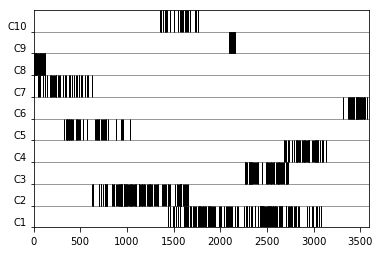

In [59]:
from eventgraphs.plotting import plot_barcode

subset = EG.events[(EG.events.time>0) & (EG.events.time<=3600)]
featured_data = EG.filter_events(subset.index)

plot_barcode(featured_data, delta_ub=90, top=10);

### Aggregate Static Graphs

Each EventGraph corresponds to an underlying aggregate graph of nodes which can be plotted.

There are also functions to just generate the graph object (Networkx Graph/DiGraph).

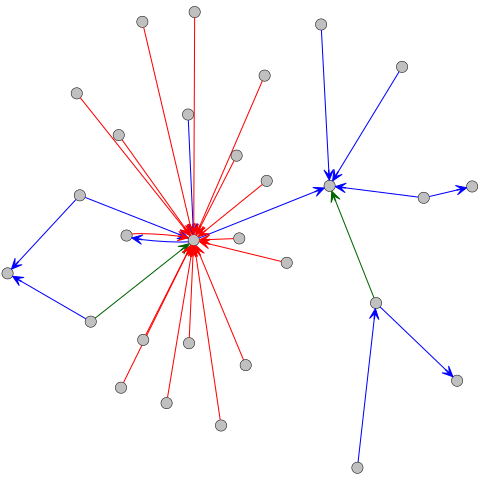

In [95]:
from eventgraphs.plotting import plot_aggregate_graph

featured_component = EG.get_component(100)

EVENT_CMAP = {'r':'red', 'm':'darkgreen'}

plot_aggregate_graph(featured_component, edge_colormap=EVENT_CMAP)

### Event Graph

We can also plot the EventGraph itself, and colour-code by the event type.
Events are arranged hierarchically.

Note: In a future release the *y* axis will represent time so that event spacings are more clearly seen.

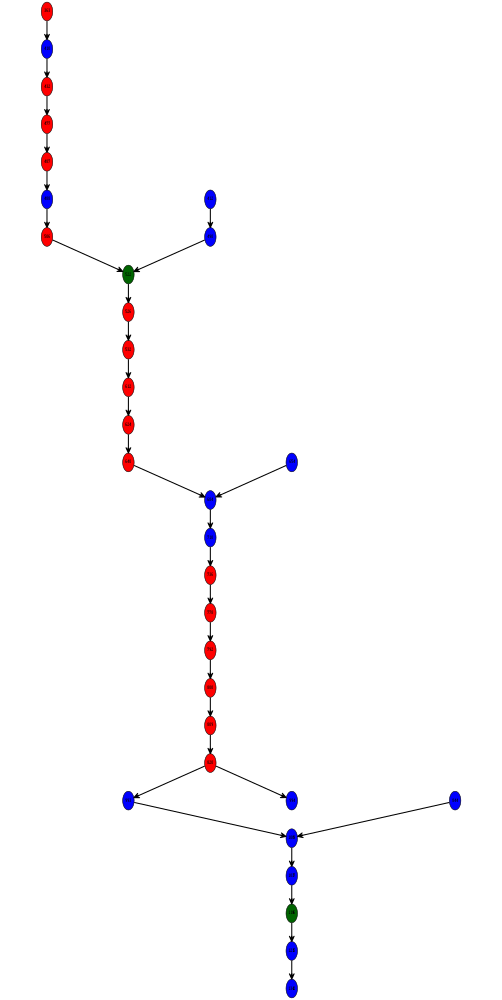

In [101]:
from eventgraphs.plotting import plot_event_graph

plot_event_graph(featured_component, event_colormap=EVENT_CMAP)

[[Back to top](#top)]

## Feature Analysis and Clustering

We now look at analysising the individual components of the EventGraph.

In [75]:
components = EG.connected_components(min_size=5)
len(components)

4683

### Generating Component Features

To generate a set of features we prescribe a *FEATURE_SPEC*.

This is split into *event_graph_features* and *aggregate_graph_features*.

Each feature has four properties: 
* name - A simple name for the feature
* scale - Whether this feature is scale-invariant (these types of features will be returned seperately)
* function - A function which operates on the EventGraph or Aggregate Graph to produce the feature
* kwargs - Any keywords to be passed to the function.

In *eventgraphs.clustering* there is already a template FEATURE_SPEC which can be used.

In [76]:
from eventgraphs.clustering import generate_features, FEATURE_SPEC

FEATURE_SPEC['event_graph_features']

[{'function': <function eventgraphs.analysis.calculate_motif_distribution>,
  'kwargs': {},
  'name': 'motifs',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_motif_entropy>,
  'kwargs': {},
  'name': 'motif_entropy',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_iet_entropy>,
  'kwargs': {},
  'name': 'iet_entropy',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_activity>,
  'kwargs': {},
  'name': 'activity',
  'scale': False},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'duration',
  'scale': True},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'num_events',
  'scale': True},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'num_nodes',
  'scale': True}]

In [77]:
features, scale_features = generate_features(components, feature_spec=FEATURE_SPEC)

In [78]:
features.head().T

,0,2,3,9,11
"+|○ (me,me)",0.000000,0.000000,0.000000,0.00000,0.000000
"+|○ (me,rt)",0.000000,0.000000,0.000000,0.00000,0.000000
"+|○ (me,ry)",0.000000,0.000000,0.000000,0.00000,0.000000
"+|○ (rt,me)",0.000000,0.000000,0.000000,0.00000,0.000000
"+|○ (rt,rt)",1.000000,0.000000,0.548017,1.00000,0.727273
"+|○ (rt,ry)",0.000000,0.000000,0.007307,0.00000,0.000000
"+|○ (ry,me)",0.000000,0.000000,0.000000,0.00000,0.000000
"+|○ (ry,rt)",0.000000,0.000000,0.006263,0.00000,0.000000
"+|○ (ry,ry)",0.000000,0.000000,0.154489,0.00000,0.000000
"+|● (me,me)",0.000000,0.000000,0.000000,0.00000,0.000000


In [79]:
scale_features.head()

,duration,edge_density,num_events,num_nodes
0,164.0,0.166667,5.0,6.0
2,123.0,0.500000,35.0,2.0
3,4773.0,0.002620,898.0,510.0
9,125.0,0.166667,5.0,6.0
11,119.0,0.111111,11.0,9.0


### Clustering

Using these features we can then perform standard clustering.

This can be done manually or through helper functions in *eventgraphs.clustering*.

In [80]:
from eventgraphs.clustering import find_clusters

max_clusters = 5
clusters, cluster_centers = find_clusters(features, max_clusters=max_clusters)

In [81]:
EG.add_cluster_assignments(clusters)

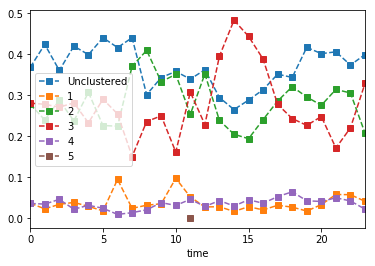

In [86]:
from eventgraphs.plotting import plot_cluster_timeseries

plot_cluster_timeseries(EG, interval_width=3600, normalized=True);

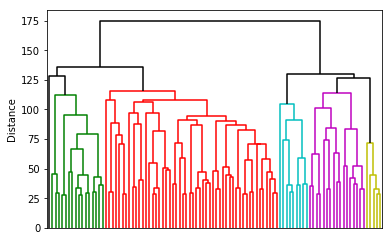

In [104]:
from eventgraphs.clustering import generate_distance_matrix, generate_linkage
from eventgraphs.plotting import plot_component_dendrogram

distances = generate_distance_matrix(features)
Z = generate_linkage(distances)

plot_component_dendrogram(Z, dendrogram_kwargs={'leaf_rotation': 90, 
                             'truncate_mode': 'lastp', 
                             'p': 100,
                             'no_labels': True, 
                             'distance_sort': False, 
                             'count_sort': True,
                             'above_threshold_color': 'k', 'color_threshold': 120});

In [84]:
from eventgraphs.clustering import reduce_feature_dimensionality

X = reduce_feature_dimensionality(features, ndim=2, method='tsne')

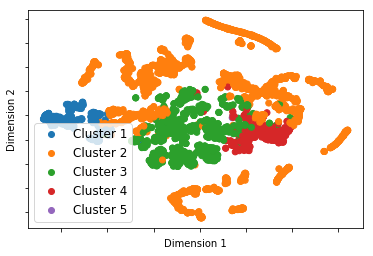

In [85]:
from eventgraphs.plotting import plot_component_embedding

plot_component_embedding(X, clusters=clusters);

## Centrality

TBD

[[Back to top](#top)]

## Joining Events on Objects

TBD

[[Back to top](#top)]